In [1]:
!pip install vision_transformer_pytorch
!pip install AdamP
!pip install git+https://github.com/albumentations-team/albumentations.git


  Created wheel for AdamP: filename=adamp-0.3.0-cp37-none-any.whl size=5999 sha256=20f07e0bb8c8e3cf3682fa8de558be284cd3e87c61116da94ae7f6c974f5e768
  Stored in directory: /root/.cache/pip/wheels/6a/89/67/879fe55977ebcbfaa5b929eb111af7fe11eb3552867850dd76
Successfully built AdamP
  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-upypok13
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-upypok13
     |████████████████████████████████| 952kB 5.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=88135 sha256=42321e9e39aaf62ab0a09f9311cc710434d02c8f1f654e3e8539d8928a2d656d
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1baa1oh/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  F

In [2]:
!pip install timm

     |████████████████████████████████| 296kB 5.8MB/s 


In [3]:
import sys
import os
import pandas as pd
import time
import datetime
import copy
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu
import numpy as np
import timm

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torchvision.transforms import RandomResizedCrop
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split


# ALBUMENTATIONS
import albumentations as albu

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

# ADAMP
# from adamp import AdamP


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_DIR="/content/drive/MyDrive/input/cassava-leaf-disease-classification"
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR,'train_images')
print(TRAIN_IMAGES_DIR)

/content/drive/MyDrive/input/cassava-leaf-disease-classification/train_images


In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/input/cassava-leaf-disease-classification/train.csv')
train_df.head()

,image_id,label
0,6103.jpg,3
1,218377.jpg,1
2,336550.jpg,3
3,469487.jpg,1
4,690163.jpg,3


In [7]:
print("Count of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

Count of training images 3000


In [8]:
with open(f'{BASE_DIR}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
train_df['class_id'] = train_df['label'].map(name_mapping)

In [9]:
print(train_df)

           image_id  label                             class_id
0          6103.jpg      3         Cassava Mosaic Disease (CMD)
1        218377.jpg      1  Cassava Brown Streak Disease (CBSD)
2        336550.jpg      3         Cassava Mosaic Disease (CMD)
3        469487.jpg      1  Cassava Brown Streak Disease (CBSD)
4        690163.jpg      3         Cassava Mosaic Disease (CMD)
...             ...    ...                                  ...
2995  595835562.jpg      4                              Healthy
2996  595909449.jpg      1  Cassava Brown Streak Disease (CBSD)
2997  596124693.jpg      2           Cassava Green Mottle (CGM)
2998  596572459.jpg      4                              Healthy
2999  596602212.jpg      3         Cassava Mosaic Disease (CMD)

[3000 rows x 3 columns]


In [10]:
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

Visualization functions

In [11]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        
        image = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        
        plt.axis("off")
        
    plt.show()
    

def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(os.path.join(TRAIN_IAMGES_DIR, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    x = transform(image=img)['image']
    plt.imshow(x)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    x = transform(image=img)['image']
    plt.imshow(x)
    
def visualize(images, transform):
    '''
    Plot images and their transformations
    '''
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

In [12]:
# CUSTOM DATASET CLASS
class CassavaDataset(Dataset):
    def __init__(
        self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_id'])
        im = cv2.imread(im_path, cv2.IMREAD_COLOR)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        
        if (self.transforms):
            '''
            When AlbumentationCompose, a dictionary with key 'image' is created
            '''
            im = self.transforms(image=im)['image']
            
        if (self.train):
            label = self.df.iloc[index]['label']
            return im, label
        else:
            return im

In [13]:
# AUGMENTATIONS
train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    CoarseDropout(p=0.5),
    Cutout(p=0.5),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [14]:
# DATA SPLIT
train, valid = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df.label.values
)

# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

# targets in train,valid datasets
train_targets = train.label.values
valid_targets = valid.label.values

In [15]:
# DEFINE PYTORCH CUSTOM DATASET
train_dataset = CassavaDataset(
    df = train,
    imfolder = TRAIN_IMAGES_DIR,
    train = True,
    transforms = train_augs
)

valid_dataset = CassavaDataset(
    df = valid,
    imfolder = TRAIN_IMAGES_DIR,
    train=True,
    transforms = valid_augs
)

print(TRAIN_IMAGES_DIR)

/content/drive/MyDrive/input/cassava-leaf-disease-classification/train_images


In [16]:
def plot_image(img_dict):
    image_tensor = img_dict[0]
#     print(type(image_tensor))
    target = img_dict[1]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0)
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


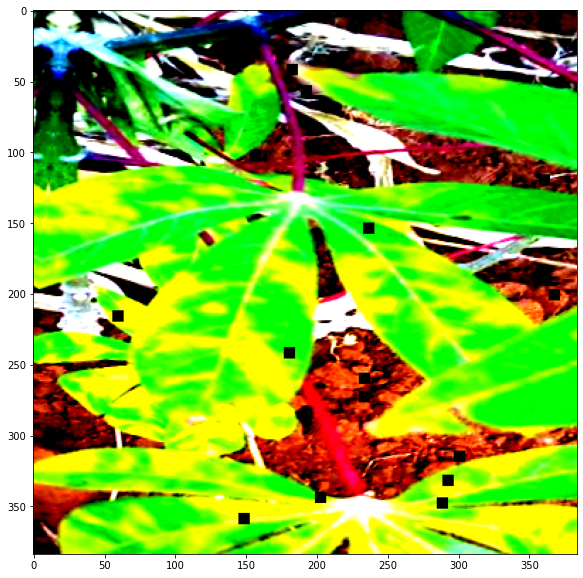

In [17]:
plot_image(train_dataset[5])

In [18]:
# MAKE PYTORCH DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    num_workers = 4,
    shuffle = True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size = 4,
    num_workers = 4,
    shuffle = False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
# TRAIN
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model


In [20]:
#class weight(nn.Module)

class efficientnet(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
    def forward(self, x):
        x = self.model(x)
        return x

class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model1 = efficientnet('tf_efficientnet_b4_ns', n_class=5)
        self.model2 = timm.create_model(model_arch, pretrained=True)
        #n_features = self.model.in_features
        self.fc1 = nn.Linear(1000, n_class)
        self.fc2 = nn.Linear(2*n_class, n_class)
        
    def forward(self, x):
        x1 = self.model1(x)
        x2 = self.model2(x)        
        x2 = self.fc1(x2)
        x3 = self.fc2(torch.cat((x1, x2), dim=1))
        return x3

In [22]:
from vision_transformer_pytorch import VisionTransformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}

# LOAD PRETRAINED ViT MODEL
#model = VisionTransformer.from_pretrained('ViT-B_16', num_classes=5)  
model = CassvaImgClassifier('vit_base_patch32_384', 5)      

# OPTIMIZER
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
# optimizer = AdamP(model.parameters(), lr=1e-4, weight_decay=0.001)

# LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

criterion = nn.CrossEntropyLoss()
num_epochs = 11

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p32_384-830016f5.pth


In [23]:
# MODEL TRAIN
trained_model = train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device)

Epoch 0/10
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8884 Acc: 0.6748
valid Loss: 0.6700 Acc: 0.7767

Epoch 1/10
----------
train Loss: 0.6796 Acc: 0.7463
valid Loss: 0.4915 Acc: 0.8300

Epoch 2/10
----------
train Loss: 0.5134 Acc: 0.8207
valid Loss: 0.4637 Acc: 0.8567

Epoch 3/10
----------
train Loss: 0.4792 Acc: 0.8319
valid Loss: 0.4604 Acc: 0.8533

Epoch 4/10
----------
train Loss: 0.4045 Acc: 0.8604
valid Loss: 0.4426 Acc: 0.8767

Epoch 5/10
----------
train Loss: 0.4101 Acc: 0.8559
valid Loss: 0.4623 Acc: 0.8700

Epoch 6/10
----------
train Loss: 0.4060 Acc: 0.8544
valid Loss: 0.4478 Acc: 0.8700

Epoch 7/10
----------
train Loss: 0.4194 Acc: 0.8574
valid Loss: 0.4527 Acc: 0.8733

Epoch 8/10
----------
train Loss: 0.3996 Acc: 0.8574
valid Loss: 0.4450 Acc: 0.8667

Epoch 9/10
----------
train Loss: 0.4058 Acc: 0.8548
valid Loss: 0.4442 Acc: 0.8667

Epoch 10/10
----------
train Loss: 0.3995 Acc: 0.8611
valid Loss: 0.4397 Acc: 0.8733

Training complete in 41m 42s
Best val Acc: 0.8767


In [ ]:
# Save the mode after training ViT
torch.save(model.state_dict(), 'vit_b-16.pt')